In [1]:
import torch
import sklearn
from sklearn.datasets import make_blobs
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import levy_stable

%matplotlib inline

In [ ]:
device = torch.device('cuda:0')

In [2]:
################# BUILD OUR TABULAR MODULE ####################

class NeuralNetwork(nn.Module):

    def __init__(self,n,out_sz,layers,p=0.5):

        super().__init__()

        ### initializing our layers

        # Our normalization layer for our continuous data. 
        #self.bn_cont = nn.BatchNorm1d(n)
        
        #number of input variables = continuous + embedded categorical
        n_in = n

        
        #sequence of layers
        layerlist = []

        for i in layers:

            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.Sigmoid())
            
            # the size of the new "input" data for the next step 
            n_in = i

        # finally our output layer
        layerlist.append(nn.Linear(layers[-1],out_sz)) # predicting a single value

        # now put this sequence in pytorch language
        self.layers = nn.Sequential(*layerlist)
    
    def loss_gradient_norm(self):

        loss_gradient_norm=0

        for name,parameter in self.named_parameters():

            loss_gradient_norm+=torch.norm(parameter.grad)

        return loss_gradient_norm
        
    def forward(self,x):
        
        #x = self.bn_cont(x)

        out = self.layers(x)

        return out


In [ ]:
device

device(type='cuda', index=0)

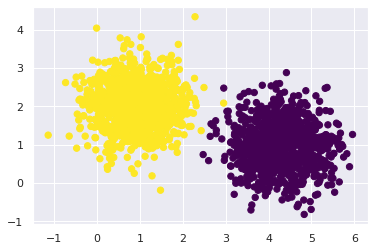

In [ ]:
# Generate some data

X, y_true = make_blobs(n_samples=2000, centers=2,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting\
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis');
plt.show()

In [ ]:
Test = pd.DataFrame(np.zeros([2000,3]))
Test.columns = ['x1','x2','target']

Test['x1'] = X[:,0]
Test['x2'] = X[:,1]
Test['target'] = y_true

In [ ]:
X = Test.drop('target',axis=1).values
y_true = Test['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y_true,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
criterion= nn.CrossEntropyLoss()

op_SGD = torch.optim.SGD(model.parameters(), lr=0.1) 


In [ ]:
X_train_gd = X_train.clone()
y_train_gd = y_train.clone()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
Train_Data = TensorDataset(X_train,y_train)

In [ ]:
import copy

In [ ]:
import time
batchsize = [50,100,200,400,1000,2000]
losssum = []
loss_gradients_SGD_sum = []
loss_gradients_GD_sum = []
for j in batchsize:
    model = NeuralNetwork(2,2,[32,32,32,32,32])
    model = model.to(device)
    criterion= nn.CrossEntropyLoss()

    op_SGD = torch.optim.SGD(model.parameters(), lr=0.1)  
    train_data = DataLoader(Train_Data,batch_size=j,shuffle=True)
    

    start_time = time.time()

    epochs = 2000
    loss_gradients_SGD=[]
    loss_gradients_GD=[]
    lses=[] 
    losses = []

    for i in range(epochs):
        i+=1
        for batch,(X_train,y_train) in enumerate(train_data):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            X_train_gd = X_train_gd.to(device)
            y_train_gd = y_train_gd.to(device)
            ################################################### - SGD GRADIENT NORM ####################
            #Deal with the loss and predicted values
            y_pred = model(X_train)

            loss=criterion(y_pred,y_train) #MSE
            losses.append(loss)
            
            op_SGD.zero_grad() # optimizing
            loss.backward() # back propagation
            
            #taking the loss gradient norm for the SGD algorithm
            loss_gradients_SGD.append(model.loss_gradient_norm())

            
            #####################################################
                    
            ################################################### - GD GRADIENT NORM ####################
            #taking the loss gradient norm for the GD algorithm
            model_GD = copy.deepcopy(model)
            op_GD = torch.optim.SGD(model_GD.parameters(), lr=0.01) 
            y_pred_gd = model_GD(X_train_gd)
            loss_gd = criterion(y_pred_gd,y_train_gd)
            op_GD.zero_grad() # optimizing
            loss_gd.backward() # back propagation

            #taking the loss gradient norm for the GD algorithm
            loss_gradients_GD.append(model_GD.loss_gradient_norm())
            
            op_SGD.step() ####### step update based on SGD
            
            duration = time.time() - start_time
        
        #calculate the loss for the whole epoch by summing the losses for every batch
        
        if i%10 == 0:
            print(f'epoch: {i} loss is {loss}')
    loss_gradients_SGD_sum.append(loss_gradients_SGD)
    loss_gradients_GD_sum.append(loss_gradients_GD)
  

tensor(-0.1299)
tensor(0.1935)
tensor(-0.1265)
tensor(0.1110)
tensor(-0.1098)
tensor(0.0784)
tensor(-0.0845)
tensor(0.0561)
tensor(-0.0560)
tensor(0.0496)
tensor(2.7940e-10)
tensor(8.9943e-09)


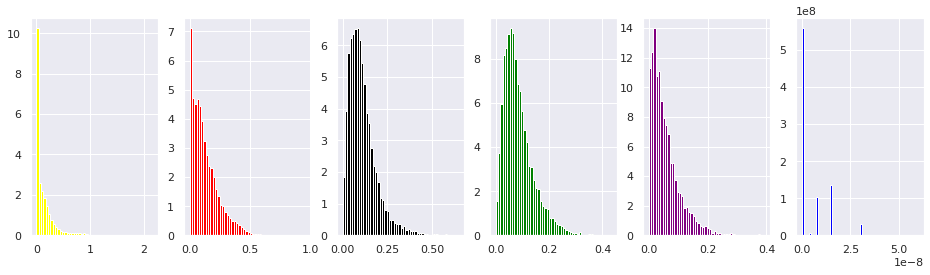

In [ ]:
Distribution_1 = (torch.Tensor(loss_gradients_GD_sum[0])-torch.Tensor(loss_gradients_SGD_sum[0]))
Distribution_2 = (torch.Tensor(loss_gradients_GD_sum[1])-torch.Tensor(loss_gradients_SGD_sum[1]))
Distribution_3 = (torch.Tensor(loss_gradients_GD_sum[2])-torch.Tensor(loss_gradients_SGD_sum[2]))
Distribution_4 = (torch.Tensor(loss_gradients_GD_sum[3])-torch.Tensor(loss_gradients_SGD_sum[3]))
Distribution_5 = (torch.Tensor(loss_gradients_GD_sum[4])-torch.Tensor(loss_gradients_SGD_sum[4]))
Distribution_6 = (torch.Tensor(loss_gradients_GD_sum[5])-torch.Tensor(loss_gradients_SGD_sum[5]))
print(torch.mean(Distribution_1))
print(torch.std(Distribution_1))
print(torch.mean(Distribution_2))
print(torch.std(Distribution_2))
print(torch.mean(Distribution_3))
print(torch.std(Distribution_3))
print(torch.mean(Distribution_4))
print(torch.std(Distribution_4))
print(torch.mean(Distribution_5))
print(torch.std(Distribution_5))
print(torch.mean(Distribution_6))
print(torch.std(Distribution_6))
Distribution_1 = torch.abs(Distribution_1)
Distribution_2 = torch.abs(Distribution_2)
Distribution_3 = torch.abs(Distribution_3)
Distribution_4 = torch.abs(Distribution_4)
Distribution_5 = torch.abs(Distribution_5)
Distribution_6 = torch.abs(Distribution_6)
figures = plt.figure(figsize=[16,4])
plt.subplot(1,6,1)
plt.hist(Distribution_1,bins=50,color='yellow',density=True)
plt.subplot(1,6,2)
plt.hist(Distribution_2,bins=50,color='red',density=True)
plt.subplot(1,6,3)
plt.hist(Distribution_3,bins=50,color='black',density=True)
plt.subplot(1,6,4)
plt.hist(Distribution_4,bins=50,color='green',density=True)
plt.subplot(1,6,5)
plt.hist(Distribution_5,bins=50,color='purple',density=True)
plt.subplot(1,6,6)
plt.hist(Distribution_6,bins=50,color='blue',density=True)
plt.show()

In [ ]:
import math
def alpha_estimator2(m,X):
    # X is N by d matrix
    N = len(X)
    n = int(N/m) # must be an integer
    Y = torch.sum(X.view(n, m, -1), 1)
    eps = np.spacing(1)
    Y_log_norm = torch.abs(torch.log(Y.norm(dim=-1) + eps))
    X_log_norm = torch.abs(torch.log(X.norm(dim=-1) + eps))

    # This can be implemented more efficiently by using 
    # the np.partition function, which currently doesn't 
    # exist in pytorch: may consider passing the tensor to np
    
    Yk = torch.sort(Y_log_norm)[0][-1]
    Xk = torch.sort(X_log_norm)[-1]
    diff = (Yk - Xk) / math.log(m)
    return 1 / diff

In [ ]:
alpha1 = alpha_estimator2(50,40,Distribution_1)
alpha2 = alpha_estimator2(100,20,Distribution_2)
alpha3 = alpha_estimator2(200,10,Distribution_3)
alpha4 = alpha_estimator2(400,5,Distribution_4)
alpha5 = alpha_estimator2(1000,2,Distribution_5)
alpha6 = alpha_estimator2(2000,1,Distribution_6)
print(alpha1,alpha2,alpha3,alpha4,alpha5,alpha6)

tensor(1.2348) tensor(1.3667) tensor(1.4041) tensor(1.5280) tensor(1.6371) tensor(0.6552)
